In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow import keras

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend


In [2]:
filename=f'{os.getcwd()}\\astraAllStarASPCAP-0.6.0.fits\\astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
header=tb[2].header
data = tb[2].data 

In [3]:
# get rid of stars with negative distances
mask_gaia = (data['zgr_plx']>0)

# use skycoord to input information, correct units
c = SkyCoord(ra=data['ra'][mask_gaia]*u.deg, dec=data['dec'][mask_gaia]*u.deg, 
             distance=(data['r_med_geo'][mask_gaia])*u.pc,
             pm_ra_cosdec=data['pmra'][mask_gaia]*u.mas/u.yr, 
             pm_dec=data['pmde'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['v_rad'][mask_gaia]*u.km/u.s) 

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))

In [4]:
# Extract the galactic coordinates and motions
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [5]:
#I clipped data table, including the the M/H and alpha/M vectors to the same length as the R and z information first before plotting
data_masked=data[mask_gaia]

In [6]:
R_kpc = R/1000
z_kpc = z/1000
r_gal_kpc = rgal/1000

In [7]:
# Age option 1 TESS data Theodoridis et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
tessraw = Table.read("Theodoridis2025.csv", format="ascii")
#this one has an age column in Gyr already so we're just going to rename it Age
tessraw['Final_age'].name='Age'
hasagetess=np.where((tessraw['Age']==tessraw['Age']) & (tessraw['Age']>0.1) &(tessraw['Flag']==0))
tess=tessraw[hasagetess]
tess

TIC,Star_type,Age,νmax,Radius_gaia,Teff_xgboost,M_H_xgboost,Logg_xgboost,Logg_seis,E_Logg_seis,Mass_seis,E_Mass_seis,Initial_mass,Teff_rgb,Teff_rc,Median_age_rgb,Median_age_rc,E_lower_age_rgb,E_upper_age_rgb,E_lower_age_rc,E_upper_age_rc,Teff_diff,Flag
int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
347020604,Clump,4.933697638292032,32.2,10.8,4766.6,-0.161,2.432,2.4173752480453827,0.0366707608673319,1.1120077414967078,0.0588614326241161,1.2303580537284051,4573.560449427352,4592.554431111989,7.362373244,4.928036510093708,6.081092717,8.892029592,4.299934128259921,6.1356166056543815,174.04556888801108,0
365250045,RGB,5.919390103924665,33.0,10.8,4931.7,-0.342,2.455,2.4229857865111493,0.0357953759646522,1.126466677413624,0.056320640605,1.1264672739859862,4667.980210870163,4834.105313542321,5.948811656,4.27541564590489,5.120775603,7.010332121,3.7125897559954217,4.990341868284544,97.59468645767902,0
377058143,RGB,10.659761236332615,59.1,7.3,4732.1,-0.519,2.615,2.677206425366256,0.0648094481080465,0.9241388003056158,0.0471439463924816,0.9241384053448526,4809.243666602538,4845.904744096898,11.11556225,5.653288060595535,9.53022434,12.72313934,4.950738403099905,6.798479977799735,-113.8047440968976,0
347548024,RGB,4.2433496208314345,33.2,11.5,4634.4,-0.213,2.388,2.4218043131513705,0.0720751969086103,1.2737524436569616,0.0852469599851652,1.2737527853903323,4625.72134164397,4775.614677688445,4.196919598,3.1842561951173276,3.279495422,5.737266629,2.7003724708906987,3.926199760609352,-141.2146776884456,0
328321210,Clump,5.297976079237009,35.7,9.6,4982.0,-0.526,2.441,2.4671643779400427,0.0755464565388593,0.9853531626679212,0.0677079590734425,1.121116190405825,4737.2709053692715,4762.055765851048,9.131354832,5.481214180765681,6.619391066,11.17929356,4.57496878200937,6.826530999798273,219.9442341489521,0
328321103,RGB,3.76901613056093,34.5,11.4,4765.0,-0.277,2.533,2.438719284222579,0.0355087401732596,1.3014095644450476,0.0659512559797257,1.301409615256684,4669.883118807332,4814.012809659391,3.7183394,2.964010779639734,3.222621332,4.398228001,2.51085645776994,3.520642797490074,-49.01280965939077,0
328324062,Clump,2.303632505100647,41.3,11.3,4792.0,0.085,2.617,2.5205598637381987,0.0266418863144747,1.5438382675435354,0.0669944467135548,1.6114631436790468,4552.67752843955,4567.434071459611,2.700422808,2.2357112051063632,2.255954628,3.155200636,1.9961451072036724,2.638300639580447,224.565928540389,0
328400618,Clump,2.159728298323744,44.1,10.5,4910.2,-0.319,2.472,2.557435937807216,0.0739867137774788,1.4511074516675977,0.0926043469167527,1.5165343396975142,4767.690838544538,4778.114861413547,2.561181642,2.157582282377099,2.082416797,3.109146383,1.7850147949917456,2.6517500725099072,132.08513858645256,0
328255103,Clump,6.418514994888695,31.9,10.8,4686.6,0.019,2.433,2.406553604071016,0.0559847430029249,1.0846413740056715,0.0674371343640133,1.18744043140101,4471.252872082005,4487.596554271885,9.075683921,6.586728636664553,7.526636104,11.69375071,5.35273124007062,7.587960124712628,199.00344572811537,0


In [8]:
agedata = tess

In [9]:
# Option 1 TESS Theodoridis et al. 2025
intersect, ind_a, ind_b = np.intersect1d(data_masked['tic_v8_id'], agedata['TIC'], return_indices=True)
print(len(ind_b))

16132


In [10]:
agedata[ind_b]

TIC,Star_type,Age,νmax,Radius_gaia,Teff_xgboost,M_H_xgboost,Logg_xgboost,Logg_seis,E_Logg_seis,Mass_seis,E_Mass_seis,Initial_mass,Teff_rgb,Teff_rc,Median_age_rgb,Median_age_rc,E_lower_age_rgb,E_upper_age_rgb,E_lower_age_rc,E_upper_age_rc,Teff_diff,Flag
int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
816261,Clump,1.8023030918124707,41.5,12.0,4637.3,0.261,2.462,2.5173994067231344,0.0420834252065156,1.728410655983844,0.0869526479320917,1.7847774939121328,4491.36230497224,4505.121669814432,2.010018296,1.8446764070455863,1.692543761,2.364767059,1.5631093979398336,2.200838738817561,132.17833018556848,0
816406,RGB,1.0483588590152084,39.8,13.4,4657.1,0.011,2.428,2.4959596620152533,0.0710579429536639,2.0514185124004967,0.1453208194770633,2.051418617424708,4664.280392163597,4670.392490129165,1.028712636,0.9571327679883002,0.867285953,1.225286797,0.7870496023881336,1.24514087257977,-13.292490129164436,0
858558,Clump,2.574277954846038,38.6,11.7,4693.0,0.263,2.549,2.4875809939849067,0.0620306198520351,1.5340437289824087,0.091672827707652,1.6029794576407483,4446.332656449375,4459.842269656546,2.890222105,2.4652316054529217,2.42086362,3.635923277,2.0226147687054503,3.0423105256948597,233.1577303434542,0
858755,Clump,2.764406010747628,11.7,19.9,4597.2,-0.293,1.915,1.964644670397434,0.0706571852354343,1.331177115275027,0.1409909139686258,1.4249618163388234,4432.8437190333525,4444.1212693935295,3.534791316,2.7253874931961053,2.370906219,4.912186922,2.0953551102041854,3.492445138549078,153.07873060647034,0
859100,Clump,6.6001432109618206,26.5,11.3,4662.9,-0.203,2.432,2.323724735980004,0.0673308868535561,0.9812206375610736,0.0695365665985554,1.125581852388303,4520.484876349873,4547.556826502292,11.07123029,6.875062392691504,8.593720807,15.22204495,5.414591495146124,8.573556466263053,115.34317349770754,0
862643,RGB,7.605498315111465,42.9,9.4,4688.0,-0.154,2.506,2.528963853276603,0.0841365007498849,1.0891922977758282,0.0711151026350944,1.089192101168278,4614.818217061526,4635.1592766442645,7.921828342,5.471697609059536,6.495915547,10.37355013,4.41622463086323,6.517077686977463,52.84072335573546,0
862777,RGB,0.5198575922620129,21.2,20.5,4687.5,-0.233,2.042,2.2205394692064835,0.0738757664979368,2.546432846685862,0.2181695044878317,2.546430940123196,4704.502873042197,4700.902103872283,0.541931501,0.5058018986228352,0.437436899,0.692550339,0.4163569220641158,0.6861457371678616,-13.402103872283078,0
862901,Clump,4.994844984058082,57.7,8.2,4794.0,-0.093,2.718,2.6722180885166025,0.0266970938395056,1.1527385295495842,0.048055380642823,1.2407202080246065,4658.079644642325,4675.767343473774,6.81745034,5.111212928966508,5.697298704,7.650831834,4.46979132951627,5.838854333386881,118.23265652622558,0
864979,RGB,3.332326720168662,52.8,9.7,4679.0,0.047,2.58,2.621702421053521,0.0372672104316309,1.4359221963654647,0.0639529098444793,1.435922736447116,4606.553086702733,4620.243295245059,3.374214575,2.761661678198747,2.908862339,3.881771447,2.400629114999044,3.1807251766839473,58.75670475494098,0


In [11]:
fullx = np.dstack([data_masked['teff'][ind_a],data_masked['logg'][ind_a], data_masked['m_h_atm'][ind_a],
                   data_masked['alpha_m_atm'][ind_a], data_masked['c_h'][ind_a], data_masked['n_h'][ind_a]])[0]

fully = np.dstack([agedata['Age'][ind_b]])[0] #for Pinsonneault 2018

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y

In [12]:
#pick some numbers
neurons_per_layer=12
layers=3
iterations=100

In [13]:

#start with an input layer
inputs = keras.Input(shape=(6,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 = keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)
layer6 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer5)
layer7 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer6)
layer8 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer7)
layer9 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer8)
layer10 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer9)
layer11 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer10)
layer12 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer11)
layer13 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer12)
layer14 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer13)
layer15 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer14)
layer16 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer15)
layer17 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer16)
layer18 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer17)
layer19 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer18)
layer20 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer19)
layer21 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer20)
layer22 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer21)
layer23 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer22)
layer24 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer23)
layer25 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer24)
layer26 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer25)
layer27 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer26)
layer28 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer27)
layer29 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer28)
layer30 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer29)
layer31 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer30)
layer32 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer31)
layer33 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer32)
layer34 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer33)
layer35 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer34)
layer36 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer35)
layer37 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer36)
layer38 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer37)
layer39 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer38)
layer40 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer39)
layer41 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer40)
layer42 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer41)
layer43 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer42)
layer44 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer43)
layer45 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer44)
layer46 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer45)
layer47 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer46)
layer48 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer47)
layer49 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer48)
layer50 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer49)

#then the output layer YOU ALSO HAVE TO MAKE THIS MATCH YOUR NUMBER OF LAYERS
outputs = keras.layers.Dense(1)(layer50)


# then we put that all together in the Model object
model = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model.summary()

Model: "test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │           15

 Total params: 7,741 (30.24 KB)

 Trainable params: 7,741 (30.24 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [15]:
tenpercent=len(agedata['Age'][ind_b])//10 #figure out what ten percent of this set of age data is

#last name before M 
trainbin=slice(0,-1*tenpercent-1)
testing=slice(-1*tenpercent,-1)

x_train, y_train = fullx[trainbin], fully[trainbin]
x_test, y_test = fullx[testing], fully[testing]

Okay now train the neural network

In [16]:
model.fit(x_train, y_train, epochs=iterations, validation_split=0.05, batch_size=300)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.0000e+00 - loss: 1.2671 - val_accuracy: 0.0000e+00 - val_loss: 0.6570
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.3910 - val_accuracy: 0.0000e+00 - val_loss: 0.2932
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.3019 - val_accuracy: 0.0000e+00 - val_loss: 0.2496
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.2668 - val_accuracy: 0.0000e+00 - val_loss: 0.2311
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.2277 - val_accuracy: 0.0000e+00 - val_loss: 0.1780
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.2081 - val_accuracy: 0.0000e+00 - val_loss: 0.1720
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.2042 - val_accuracy: 0.0000e+00 - val_loss: 0.1712
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

In [17]:
DR19x = np.dstack([data_masked['teff'],data_masked['logg'], data_masked['m_h_atm'],
                   data_masked['alpha_m_atm'], data_masked['c_h'], data_masked['n_h']])[0]
print(len(data_masked['teff']))

DR19x= DR19x/scaling_x

predictionsDR19 = model.predict(DR19x)

963539
30111/30111 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step


## Section 7: Paper Tasks

__Task #32:__ Fig 2. Four panels for the full DR19 dataset: alpha/fe vs fe/h, Z vs R gal, alpha/M vs C/N, and logg vs teff, all color coded by something sensible 

In [18]:
DR19_pd = pd.DataFrame({
    '[α/Fe]': (data_masked['alpha_m_atm']-data_masked['fe_h']).astype('float32'),
    '[Fe/H]': data_masked['fe_h'].astype('float32'),
    'Z (kpc)': z_kpc,
    'R_gal (kpc)': r_gal_kpc,
    '[α/M]': data_masked['alpha_m_atm'].astype('float32'),
    '[C/N]': (data_masked['c_h']-data_masked['n_h']).astype('float32'),
    'Log_g': data_masked['logg'].astype('float32'),
    'T_eff': data_masked['teff'].astype('float32'),
    'Predicted_age': predictionsDR19.ravel()
})
DR19_pd

,[α/Fe],[Fe/H],Z (kpc),R_gal (kpc),[α/M],[C/N],Log_g,T_eff,Predicted_age
0,-0.086501,0.036716,-0.042422,8.003237,-0.049785,-0.320997,2.561960,4521.324707,0.647648
1,-0.134628,0.082482,-0.045911,8.000944,-0.052146,-0.319170,2.574178,4745.399902,0.682038
2,-0.151757,0.051216,-0.048636,7.994735,-0.100541,-0.749890,2.396280,4687.408691,0.457311
3,-0.206624,0.152679,-0.046894,8.008039,-0.053945,-0.408940,2.595649,4726.982910,0.575637
4,0.197169,-0.193401,0.684357,10.230661,0.003768,NaN,0.736285,3542.665527,1.813925
...,...,...,...,...,...,...,...,...,...
963534,0.511827,-0.466151,1.143305,9.525971,0.045676,-0.061100,2.090511,4585.859375,1.036280
963535,NaN,NaN,-2.278966,5.654070,NaN,NaN,NaN,NaN,1.813925
963536,-0.451189,0.359463,-0.192352,7.764072,-0.091726,-1.899260,3.563128,6210.836426,0.733733
963537,-0.103436,0.080672,-0.319612,8.006440,-0.022764,-0.204084,3.376096,4855.964844,1.334383


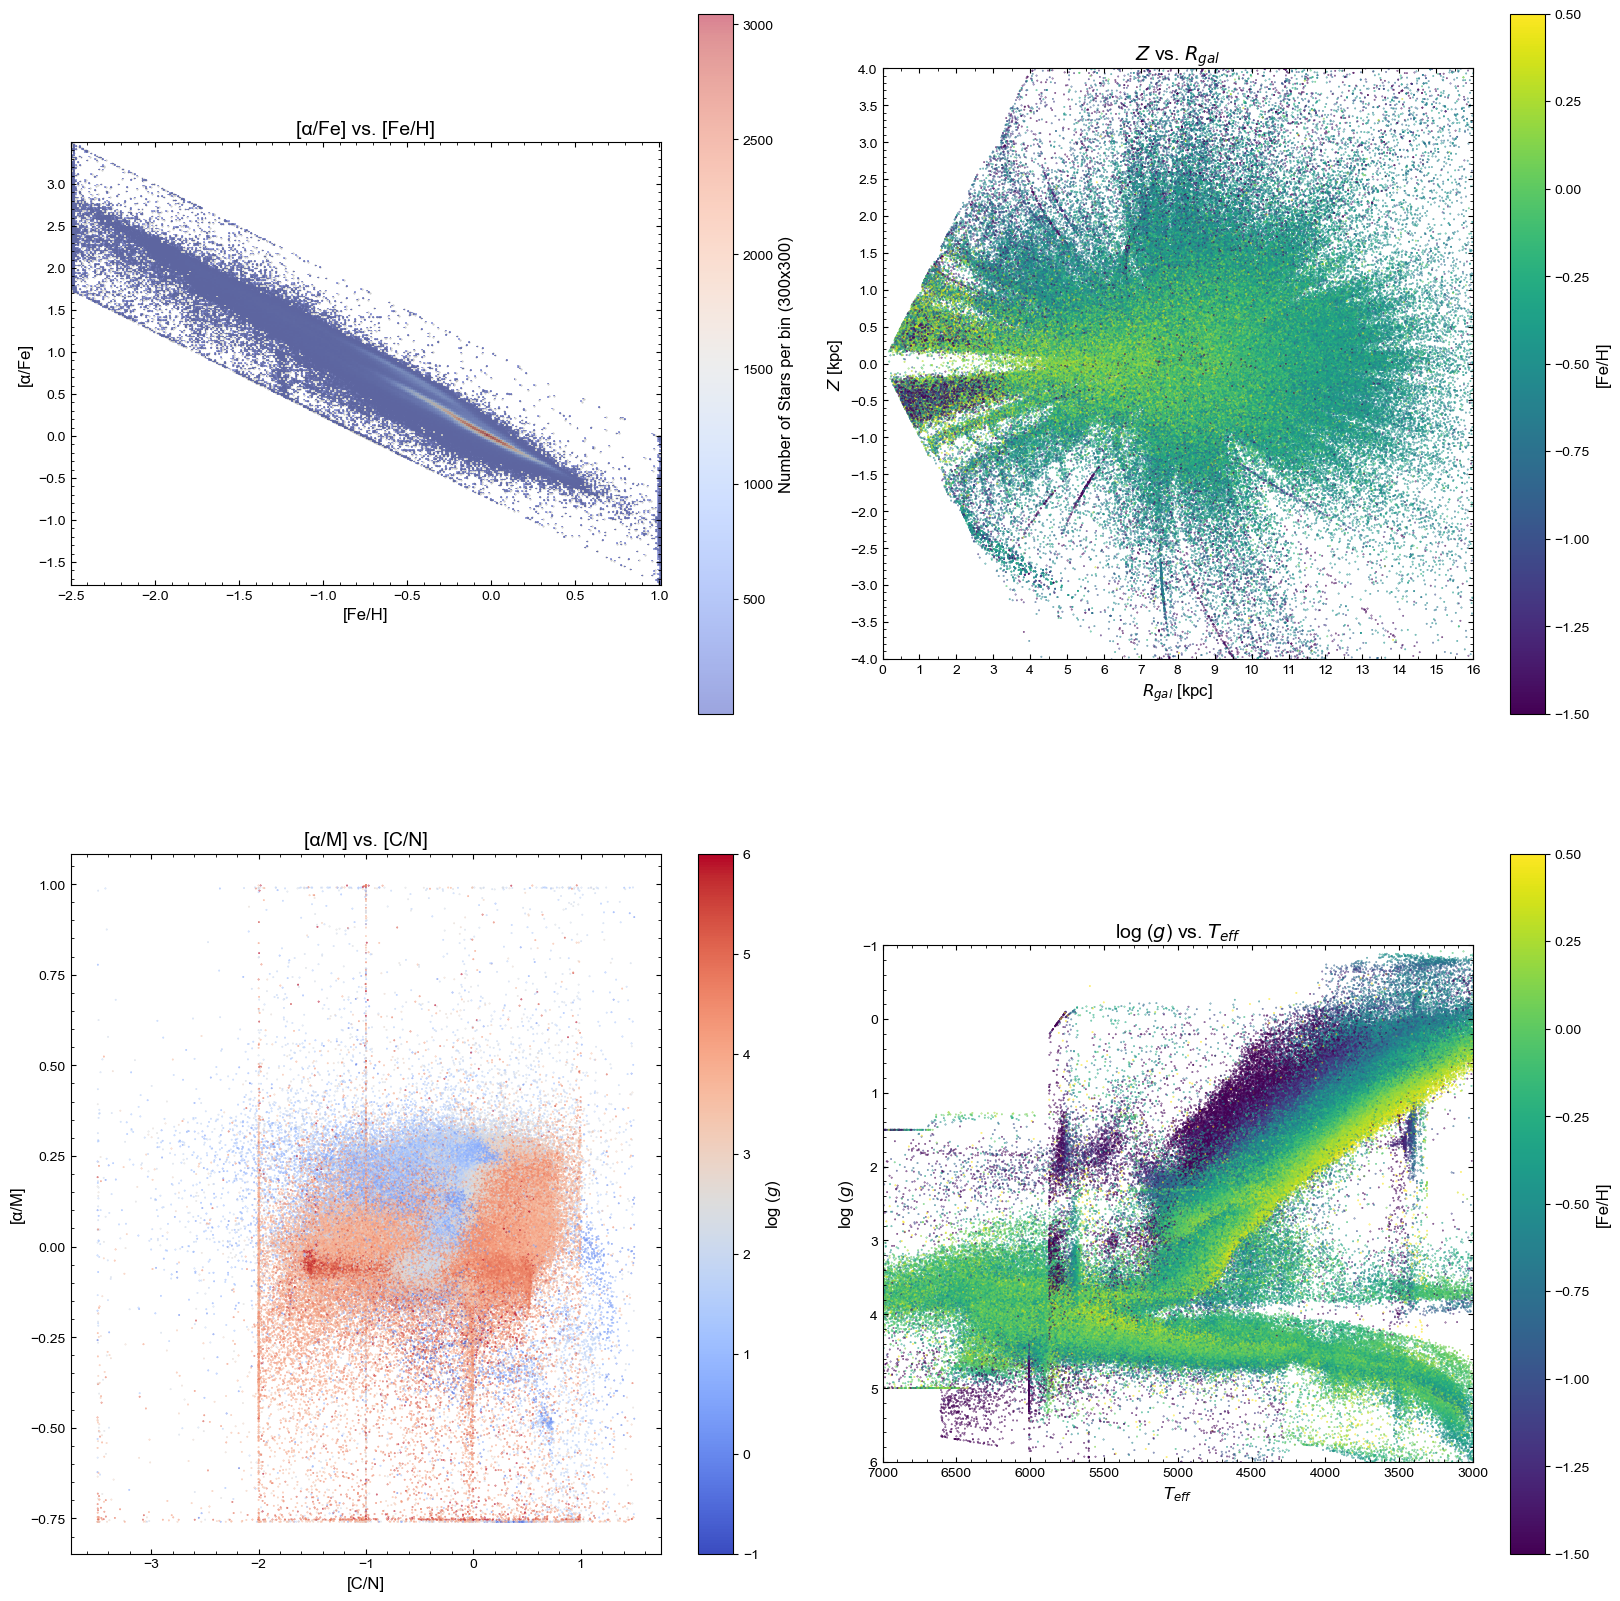

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20,20)) # rows, columns

# Top-left panel
cmap_1 = plt.cm.coolwarm
cmap_1.set_under('white') # makes bins white if it has no data points
DR19_pd_no_nan = DR19_pd.dropna(subset=['[Fe/H]', '[α/Fe]']) # removing 'NaN' values from these two columns

ax[0,0].scatter(DR19_pd['[Fe/H]'], DR19_pd['[α/Fe]'], s=0.2, color='grey')
hist, xedges, yedges, plot_1 = ax[0, 0].hist2d(DR19_pd_no_nan['[Fe/H]'], DR19_pd_no_nan['[α/Fe]'], bins=300, cmap=cmap_1, alpha=0.5, vmin=1e-5) # vmin=1e-5 makes bins white if it has no data points
cbar_1 = fig.colorbar(plot_1, ax=ax[0,0])
cbar_1.set_label('Number of Stars per bin (300x300)')
ax[0,0].set_aspect(0.5)
ax[0,0].tick_params(axis='both', direction='in', which='major', right=True, top=True) # adds ticks to the top and right axes
ax[0,0].tick_params(axis='both', direction='in', which='minor', right=True, top=True) # adds ticks to the top and right axes
ax[0,0].xaxis.set_major_locator(ticker.MultipleLocator(0.5)) # adjusts the frequency of ticks
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # adjusts the frequency of ticks
ax[0,0].yaxis.set_major_locator(ticker.MultipleLocator(0.5)) # adjusts the frequency of ticks
ax[0,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # adjusts the frequency of ticks
ax[0,0].set_ylabel('[α/Fe]')
ax[0,0].set_xlabel('[Fe/H]')
ax[0,0].set_title('[α/Fe] vs. [Fe/H]')

# Top-right panel
plot_2 = ax[0,1].scatter(DR19_pd['R_gal (kpc)'], DR19_pd['Z (kpc)'], s=0.1, c=DR19_pd['[Fe/H]'], cmap='viridis', vmin=-1.5, vmax=0.5)
cbar_2 = fig.colorbar(plot_2, ax=ax[0,1])
cbar_2.set_label('[Fe/H]')
ax[0,1].set_aspect(2)
ax[0,1].tick_params(axis='both', direction='in', which='major', right=True, top=True) # adds ticks to the top and right axes
ax[0,1].tick_params(axis='both', direction='in', which='minor', right=True, top=True) # adds ticks to the top and right axes
ax[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1)) # adjusts the frequency of ticks
ax[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.5)) # adjusts the frequency of ticks
ax[0,1].yaxis.set_major_locator(ticker.MultipleLocator(0.5)) # adjusts the frequency of ticks
ax[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # adjusts the frequency of ticks
ax[0,1].set_xlim(0, 16)
ax[0,1].set_ylim(-4, 4)
ax[0,1].set_ylabel('$Z$ [kpc]')
ax[0,1].set_xlabel('$R_{gal}$ [kpc]')
ax[0,1].set_title('$Z$ vs. $R_{gal}$')

# Bottom-left panel
plot_3 = ax[1,0].scatter(DR19_pd['[C/N]'], DR19_pd['[α/M]'], s=0.1, c=DR19_pd['Log_g'], cmap='coolwarm', vmin=-1, vmax=6)
cbar_3 = fig.colorbar(plot_3, ax=ax[1,0])
cbar_3.set_label('log ($g$)')
# ax[1,0].set_aspect(2)
ax[1,0].tick_params(axis='both', direction='in', which='major', right=True, top=True) # adds ticks to the top and right axes
ax[1,0].tick_params(axis='both', direction='in', which='minor', right=True, top=True) # adds ticks to the top and right axes
ax[1,0].xaxis.set_major_locator(ticker.MultipleLocator(1)) # adjusts the frequency of ticks
ax[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.2)) # adjusts the frequency of ticks
ax[1,0].yaxis.set_major_locator(ticker.MultipleLocator(0.25)) # adjusts the frequency of ticks
ax[1,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.05)) # adjusts the frequency of ticks
ax[1,0].set_ylabel('[α/M]')
ax[1,0].set_xlabel('[C/N]')
ax[1,0].set_title('[α/M] vs. [C/N]')

# Bottom-right panel
plot_4 = ax[1,1].scatter(DR19_pd['T_eff'], DR19_pd['Log_g'], s=0.1, c=DR19_pd['[Fe/H]'], cmap='viridis', vmin=-1.5, vmax=0.5)
cbar_4 = fig.colorbar(plot_4, ax=ax[1,1])
cbar_4.set_label('[Fe/H]')
ax[1,1].set_aspect(500)
ax[1,1].tick_params(axis='both', direction='in', which='major', right=True, top=True) # adds ticks to the top and right axes
ax[1,1].tick_params(axis='both', direction='in', which='minor', right=True, top=True) # adds ticks to the top and right axes
ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(500)) # adjusts the frequency of ticks
ax[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(100)) # adjusts the frequency of ticks
ax[1,1].yaxis.set_major_locator(ticker.MultipleLocator(1)) # adjusts the frequency of ticks
ax[1,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.2)) # adjusts the frequency of ticks
ax[1,1].set_ylim(6, -1)
ax[1,1].set_xlim(7000, 3000)

ax[1,1].set_ylabel('log ($g$)')
ax[1,1].set_xlabel('$T_{eff}$')
ax[1,1].set_title('log ($g$) vs. $T_{eff}$')

plt.subplots_adjust(wspace=0.1, hspace=0.2)
# plt.suptitle('SDSS Data Release 19') # title for the entire 4-plot figure, if needed
plt.show()